# Anomaly detection

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix,f1_score, roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import scipy.stats as stats
import pylab
import seaborn as sns

import sklearn
import scipy
import matplotlib
import warnings
warnings.filterwarnings('ignore')


Set the Bnab type and the HIV immmune donors experiment to process

In [69]:
SEEDNUMBER=1
BNAB="gp120_CD4BS"  # The 5 bnab types are:  gp120_CD4BS     gp120_V2      gp120_V3     gp41_MPER     gp41-gp120_interface
DATAPATH="input_data/"
if not os.path.exists("output/"):
    os.mkdir("output/")
OUTPUTPATH="output/"+BNAB+"/"
if not os.path.exists(OUTPUTPATH):
    os.mkdir(OUTPUTPATH)
#here we set the HIV donors experiment to process
EXP="G4"
EXPPATH="HIVdonors_AIRR/"+EXP+"/" #or  "HIVdonors_AIRR/"+EXP+"/" or "HIVdonors_FILES/"+EXP+"/"

# HERE to have the same color than for the DC and RF
colors = ["darksalmon", "lightsteelblue"]
customPalette = sns.set_palette(sns.color_palette(colors))


In [70]:
#some functions

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)


def select_threshold(probs, yval):
    tplist=[]
    fplist=[]
    validation_accuracies=[]
    validation_aucs=[]
    validation_TPs=[]
    validation_FPs=[]
    best_epsilon = 0
    best_f1 = 0
    best_tp = 0
    best_fp = sum(yval == 0)
    #print("best fp is = ",best_fp)
    best_precision=0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000 
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        #print(predictions)
        tp = sum(np.logical_and(predictions == 1, yval == 1))
        fp = sum(np.logical_and(predictions == 1, yval == 0))
        fn = sum(np.logical_and(predictions == 0, yval == 1))
        tn = sum(np.logical_and(predictions == 0, yval == 0))
        validation_FPs.append(fp)
        validation_TPs.append(tp)
        fpr = fp / (fp+tn)
        if tp == 0:
            tp=0.001 #to not have a zero val
        fplist.append(fpr)
        # Precision or positive predictive value 
        # (the ability of the classifier not to label a negative sample as positive)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        accu = (tp+tn)/(tp+tn+fp+fn)
        validation_accuracies.append(accu)
        auc = roc_auc_score(yval,predictions)
        validation_aucs.append(auc)
        tplist.append(recall)
        f = (2 * precision * recall) / (precision + recall)
        #print("For f "+ str(f) + " and epsilon "+str(epsilon))
        #print("   precision= "+str(precision))
        #print("   recall/TPR= "+str(recall))
        #print("   FPR= "+str(fpr))
        #print("   FP= "+str(fp)+"--")
        if(fp<best_fp and tp >=1):
            best_f1 = f
            best_epsilon = epsilon
            best_predictions = predictions
            best_precision = precision
            best_tp=tp
            best_fp=fp

    return best_f1, best_epsilon, tplist, fplist, best_predictions, best_precision, best_fp,best_tp,validation_accuracies,validation_aucs,validation_FPs,validation_TPs,epsilons



### Let us explore our dataset.

In [71]:
data=pd.read_csv(DATAPATH+"features_table_"+BNAB+".tsv",sep='\t')


In [72]:

data.skew()

HCDR3.length             0.361746
hcdr3.hydrophobicity     0.701408
LCDR3.length             0.379686
mut.freq                 0.796924
fwrs.mut.freq            1.208048
VH1.lcdr3_5             22.691362
VH1-69.VK3-20.GW         0.000000
is.bnAb                 16.587123
dtype: float64

###  We normalize the data (features tables) 

In [73]:
#we used the HIV donors data too
donordata_not_normalized=pd.read_csv(EXPPATH+EXP+"_featuresTable.tsv",sep='\t')
data=pd.read_csv(DATAPATH+"features_table_"+BNAB+".tsv",sep='\t')
dondata = donordata_not_normalized.copy();

data_to_norm= pd.concat([data, dondata])

#we normalize by column
d = preprocessing.normalize(data_to_norm[["HCDR3.length","hcdr3.hydrophobicity","LCDR3.length","mut.freq","fwrs.mut.freq"]], axis=0) 
data_to_norm[["HCDR3.length","hcdr3.hydrophobicity","LCDR3.length","mut.freq","fwrs.mut.freq"]] = pd.DataFrame(d)
selected = dondata['sequence_id']
#now we remove the donor data
data= data_to_norm[-data_to_norm['sequence_id'].isin(selected)]
del data["sequence_id"]
data.head()


,vh.gene,HCDR3.length,hcdr3.hydrophobicity,vl.gene,LCDR3.length,mut.freq,fwrs.mut.freq,VH1.lcdr3_5,VH1-69.VK3-20.GW,is.bnAb
0,IGHV3-66,0.008867,0.009425,IGKV1-5,0.006556,0.000678,0.000798,0,0,0.0
1,IGHV4-59,0.005320,0.003504,IGKV4-1,0.006556,0.005421,0.005583,0,0,0.0
2,IGHV6-1,0.003104,0.002296,IGKV4-1,0.006556,0.000000,0.000000,0,0,0.0
3,IGHV3-48,0.008867,0.005075,IGLV3-19,0.007284,0.012197,0.011964,0,0,0.0
4,IGHV4-59,0.005320,0.008700,IGLV1-47,0.008012,0.000678,0.000798,0,0,0.0


HCDR3.length is Normally distributed

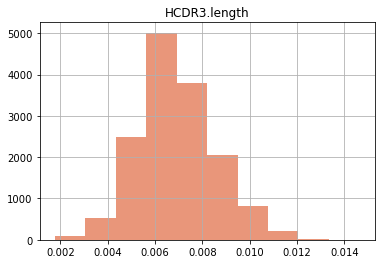

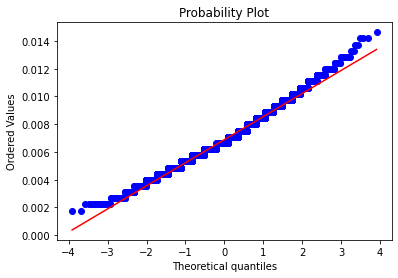

In [74]:
data["HCDR3.length"].hist()
plt.title("HCDR3.length")
plt.show()

stats.probplot(data["HCDR3.length"],plot=pylab);

LCDR3.length is Normally distributed

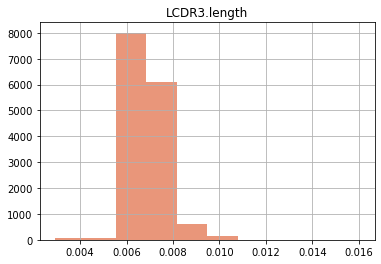

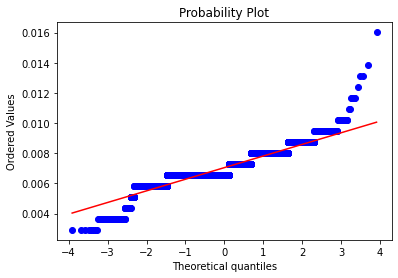

In [75]:
data["LCDR3.length"].hist()
plt.title("LCDR3.length")
plt.show()

stats.probplot(data["LCDR3.length"],plot=pylab);

HCDR3.hydrophobicity is Normally distributed

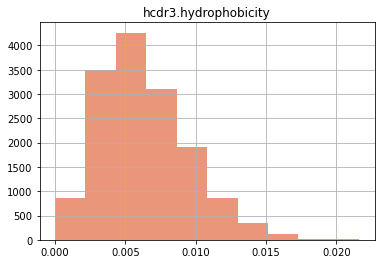

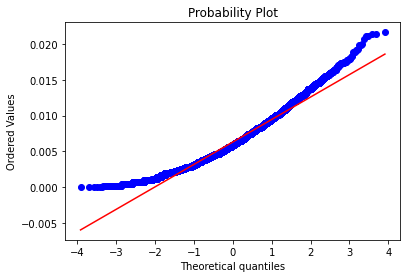

In [76]:
data["hcdr3.hydrophobicity"].hist()
plt.title("hcdr3.hydrophobicity")
plt.show()
stats.probplot(data["hcdr3.hydrophobicity"],plot=pylab);

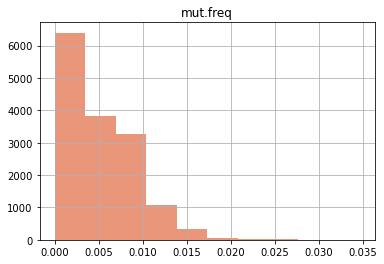

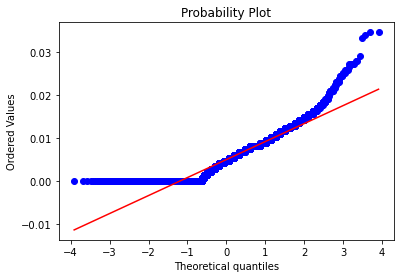

In [77]:
data["mut.freq"].hist()
plt.title("mut.freq")
plt.show()
stats.probplot(data["mut.freq"],plot=pylab);

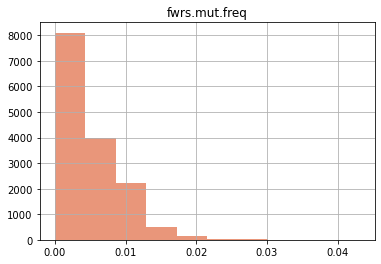

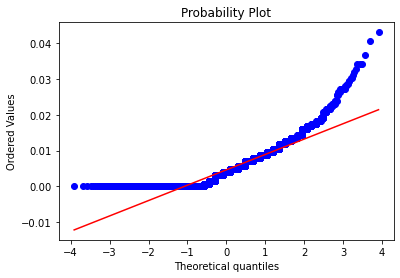

In [78]:
data["fwrs.mut.freq"].hist()
plt.title("fwrs.mut.freq")
plt.show()
stats.probplot(data["fwrs.mut.freq"],plot=pylab);

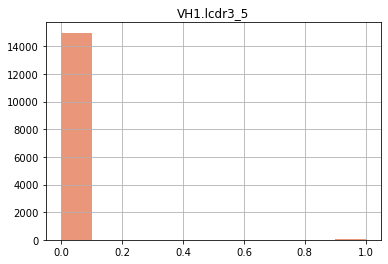

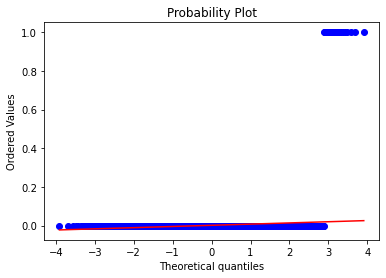

In [79]:
data["VH1.lcdr3_5"].hist()
plt.title("VH1.lcdr3_5")
plt.show()
stats.probplot(data["VH1.lcdr3_5"],plot=pylab);

We will generate random number for 0 values with SD of 0.2 and keep the value 1 as 1 to have a Gaussian distribution

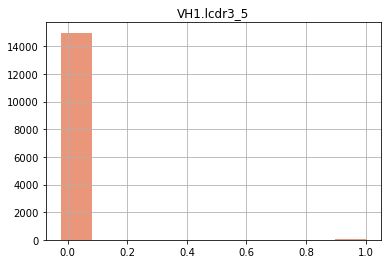

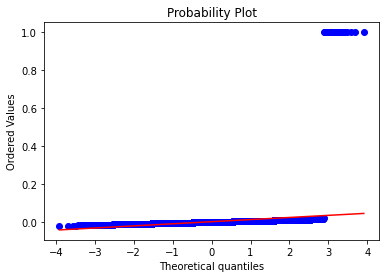

In [80]:
#make some random value with a gaussian distrib for the zero values
rng = np.random.default_rng()
gausval=rng.normal(0.0, 0.005, len(data))
for index,row in enumerate(data["VH1.lcdr3_5"]):
    if(row==0):
        data.at[index,"VH1.lcdr3_5"] =gausval[index]

data["VH1.lcdr3_5"].hist()
plt.title("VH1.lcdr3_5")
plt.show()
stats.probplot(data["VH1.lcdr3_5"],plot=pylab);


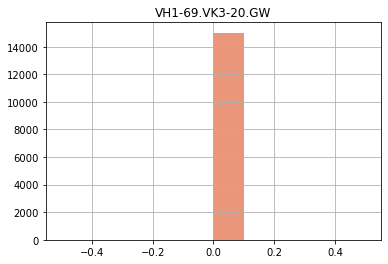

In [81]:
data["VH1-69.VK3-20.GW"].hist()
plt.title("VH1-69.VK3-20.GW")
plt.show()

Make this values as Gaussian distribution

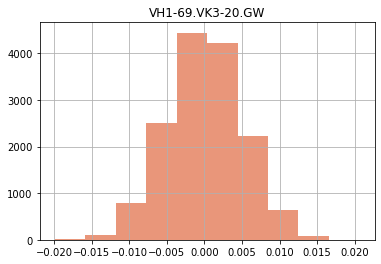

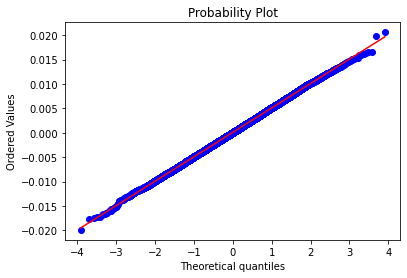

In [82]:
#make some random value with a gaussian distrib for the zero values
rng = np.random.default_rng()
gausval=rng.normal(0.0, 0.005, len(data))
for index,row in enumerate(data["VH1-69.VK3-20.GW"]):
    if(row==0):
        data.at[index,"VH1-69.VK3-20.GW"] =gausval[index]

data["VH1-69.VK3-20.GW"].hist()
plt.title("VH1-69.VK3-20.GW")
plt.show()
stats.probplot(data["VH1-69.VK3-20.GW"],plot=pylab);

Let's use only the features that are important for each antigenic site

In [83]:
# gp120_CD4BS     gp120_V2      gp120_V3     gp41_MPER     gp41-gp120_interface
if (BNAB == "gp120_CD4BS"):
    df=data[["mut.freq","fwrs.mut.freq","VH1.lcdr3_5","is.bnAb"]]

elif (BNAB == "gp41_MPER"):
    df=data[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","VH1-69.VK3-20.GW","is.bnAb"]]

elif (BNAB == "gp120_V2"):
    df=data[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length","is.bnAb"]]

elif (BNAB == "gp120_V3"):
    df=data[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length","is.bnAb"]]

elif (BNAB == "gp41-gp120_interface"):
    df=data[["mut.freq","fwrs.mut.freq","is.bnAb"]]

df.head(3)

,mut.freq,fwrs.mut.freq,VH1.lcdr3_5,is.bnAb
0,0.000678,0.000798,0.003604,0.0
1,0.005421,0.005583,0.000535,0.0
2,0.000000,0.000000,0.000704,0.0


### Split the dataset into training, validation and test sets
The training dataset is only composed of NON-bNabs

In [84]:

seed=SEEDNUMBER
np.random.seed(seed)
random.seed(seed)
random_state=seed

training,test,trainingtarget,testtarget=train_test_split(df.loc[:,df.columns != "is.bnAb"],df.loc[:,"is.bnAb"],
                                                         test_size=0.2,random_state=random_state)
training,validation,trainingtarget,validationtarget=train_test_split(training,trainingtarget,
                                                                     test_size=0.25,random_state=random_state) 

#we have to remove the bNabs from the training dataset
print("number of data in the trainingtarget dataset ",len(trainingtarget))
bnab_indexes = [n for n,x in enumerate(trainingtarget) if x==1]
nobnab_indexes = [n for n,x in enumerate(trainingtarget) if x==0]
print(bnab_indexes)
print("No bnabs data are ", len(nobnab_indexes))
def remove_by_indices(iter, idxs):
    return [e for i, e in enumerate(iter) if i not in idxs]
trainingtarget=remove_by_indices(trainingtarget,bnab_indexes)
print("number of bnabs to delete from the training dataset: ",len(bnab_indexes))
print("number of data in the trainingtarget dataset ",len(trainingtarget))
print(training.shape)
train_data = np.take(training,nobnab_indexes, axis=0)
print("Data use for the training dataset: ",train_data.shape)

crossval_data=validation
crossval_data_Y =validationtarget

test_data=test
test_data_Y=testtarget


number of data in the trainingtarget dataset  9009
[158, 344, 381, 456, 685, 816, 1240, 1327, 2028, 2196, 2448, 2607, 2632, 3522, 4004, 4177, 4713, 5155, 5258, 6171, 7364, 7474, 7823, 8021, 8656, 8769]
No bnabs data are  8983
number of bnabs to delete from the training dataset:  26
number of data in the trainingtarget dataset  8983
(9009, 3)
Data use for the training dataset:  (8983, 3)


### Estimate Gaussian for the training dataset

In [85]:
mu, sigma = estimate_gaussian(train_data)
print(mu)
print(sigma)

mut.freq         0.004966
fwrs.mut.freq    0.004617
VH1.lcdr3_5      0.000163
dtype: float64
[[1.82528169e-05 1.83021263e-05 9.57716027e-07]
 [1.83021263e-05 1.99095718e-05 1.35505790e-06]
 [9.57716027e-07 1.35505790e-06 2.47960284e-04]]


### Selecting optimal value of epsilon using cross validation

Fscore and epsilon values:
0.45833333333333326 732.2928306493635
AUC =  0.8629852744310577
precision =  0.3333333333333333
FP =  22
TP =  11
[[2966   22]
 [   4   11]]
732.2928306493635


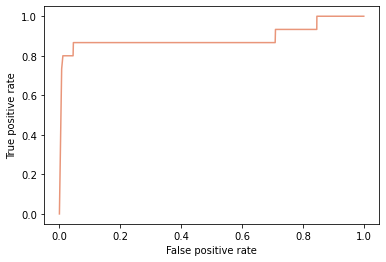

In [86]:
validation_accuracies=[]
validation_aucs=[]
validation_TPs=[]
validation_FPs=[]
p_cv = multivariate_gaussian(crossval_data,mu,sigma)
yvalues = np.reshape(crossval_data_Y, len(crossval_data_Y))
fscore, ep, tplist, fplist,predictions, prec, fp,tp,validation_accuracies,validation_aucs,validation_FPs,validation_TPs,epsilons = select_threshold(p_cv, yvalues)
print("Fscore and epsilon values:")
print(fscore, ep)
plt.plot(fplist,tplist)
# naming the x axis
plt.xlabel('False positive rate')
# naming the y axis
plt.ylabel('True positive rate')
#plt.ylim(0,1)
#plt.xlim(0,1)
auc = roc_auc_score(yvalues,predictions)
print("AUC = ",auc)
print("precision = ",prec)
print("FP = ",fp)
print("TP = ",tp)
cm=confusion_matrix(crossval_data_Y,predictions)
print(cm)
tn_v, fp_v, fn_v, tp_v = cm.ravel()
auc_v=auc
print(ep)

In [87]:
greek_letterz=[chr(code) for code in range(945,970)]
toprint=greek_letterz[4]+"= "+str(float(np.round(ep, 2)))
print(toprint)


ε= 732.29


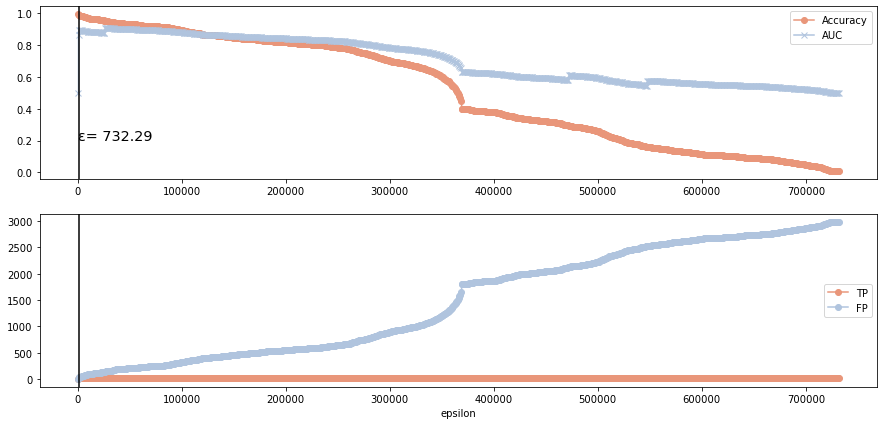

In [88]:

fig,ax=plt.subplots(2,1,figsize=(15, 7))

line1, =ax[0].plot(epsilons,validation_accuracies,marker='o',drawstyle="steps-post",label='Accuracy')
line2, = ax[0].plot(epsilons,validation_aucs,marker='x',drawstyle="steps-post",label='AUC')
ax[0].axvline(x=ep, color='black')
ax[0].text(500,0.2,toprint,fontsize='x-large')
#ax[0].set_xlabel("epsilon")
ax[0].legend(handles=[line1, line2])

line1, =ax[1].plot(epsilons,validation_TPs,marker='o',drawstyle="steps-post",label='TP')
line2, =ax[1].plot(epsilons,validation_FPs,marker='o',drawstyle="steps-post",label='FP')
ax[1].axvline(x=ep, color='black')
ax[1].set_xlabel("epsilon")
ax[1].legend(handles=[line1, line2])

#plt.show()
plt.savefig(OUTPUTPATH+'anomaly_detection_AUC_TP_FP_plots_'+BNAB+'_seed'+str(SEEDNUMBER)+'.svg', bbox_inches='tight')

#### Save the TP and FP for the validation data set into text file to compare them with the 2 other ML methods

In [89]:
#Make a big table with predicted and known bnab
# Save TP and FP in txt files to compare them with the 2 other methods
valTable= crossval_data.copy()
valTable['is_bnab']= crossval_data_Y
valTable['predicted'] = predictions
df=valTable[(valTable['predicted'] == 1) & (valTable['is_bnab'] == 0)]
#print(df)
df.to_csv(OUTPUTPATH+'validation_FP_anomaly_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
df=valTable[(valTable['predicted'] == 1) & (valTable['is_bnab'] == 1)]
df.to_csv(OUTPUTPATH+'validation_TP_anomaly_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
df.head()

,mut.freq,fwrs.mut.freq,VH1.lcdr3_5,is_bnab,predicted
14977,0.026428,0.034296,0.000302,1.0,True
14962,0.021007,0.023130,1.000000,1.0,True
14995,0.034559,0.043069,1.000000,1.0,True
15014,0.024395,0.028713,1.000000,1.0,True
14970,0.027783,0.031903,-0.004466,1.0,True


### Selecting outlier datapoints from the test set

In [90]:
p = multivariate_gaussian(test_data,mu,sigma)
#print(p)
outliers = np.asarray(np.where(p < ep))
predic = []
for row in p:
    if row <ep: predic.append(1)
    else: predic.append(0)
print(test_data.shape)
print(outliers[0])

cm=confusion_matrix(test_data_Y,predic)
print(cm)
tn_t, fp_t, fn_t, tp_t = cm.ravel()
auc_t= roc_auc_score(test_data_Y,predic)

(3004, 3)
[  30   84  284  322  358  412  474  495  611  747  767 1047 1048 1199
 1500 1564 1681 1718 1822 1848 1874 2015 2031 2080 2107 2120 2128 2196
 2262 2588 2819 2856 2875]
[[2968   23]
 [   3   10]]


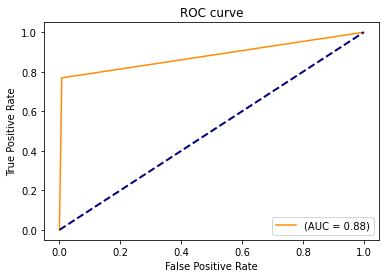

In [91]:
fpr,tpr,thresholds=roc_curve(test_data_Y,predic)

AUC=roc_auc_score(test_data_Y,predic)
auc_t = AUC

plt.plot(fpr,tpr,color="darkorange",label="(AUC = %0.2f)"%auc_t)
plt.plot([0, 1],[0, 1],color="navy",lw=2,linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title('ROC curve')
#plt.show()
plt.savefig(OUTPUTPATH+'AnoDetec_ROCcurve_'+BNAB+'_seed'+str(SEEDNUMBER)+'.pdf', bbox_inches='tight')

### Save TP and FP into text files

In [92]:

#Make a big table with predicted and known bnab
# Save TP and FP in txt files to compare them with the 2 other methods
testTable= test_data.copy()
testTable['is_bnab']= test_data_Y
testTable['predicted'] = predic
df=testTable[(testTable['predicted'] == 1) & (testTable['is_bnab'] == 0)]
print(df)
df.to_csv(OUTPUTPATH+'test_FP_anomaly_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
df=testTable[(testTable['predicted'] == 1) & (testTable['is_bnab'] == 1)]
#print(df)
df.to_csv(OUTPUTPATH+'test_TP_anomaly_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")


       mut.freq  fwrs.mut.freq  VH1.lcdr3_5  is_bnab  predicted
10035  0.014908       0.018344     0.007135      0.0          1
10019  0.010165       0.014356     0.002796      0.0          1
6261   0.005421       0.000000    -0.005941      0.0          1
1365   0.019651       0.021534     0.010689      0.0          1
1662   0.011520       0.015951     0.000380      0.0          1
2080   0.016941       0.020737    -0.002710      0.0          1
13180  0.010165       0.004785     0.004601      0.0          1
6270   0.020329       0.021534    -0.005590      0.0          1
4928   0.014230       0.018344    -0.004167      0.0          1
12145  0.008132       0.001595    -0.004700      0.0          1
6433   0.010842       0.015951    -0.005362      0.0          1
6391   0.010165       0.014356    -0.003874      0.0          1
7666   0.020329       0.020737    -0.015046      0.0          1
9266   0.010842       0.005583    -0.006207      0.0          1
397    0.018974       0.014356     0.001

In [93]:
print("algo"+"\t"+"BnAb"+"\t"+"seed"+"\t"+"criterion"+"\t"+"RF.max.samples"+"\t"+"RF.max.depth"+"\t"+"TPval"+"\t"+"FPval"+"\t"+"TNval"+"\t"+"FNval"+"\t"+"AUCval"+"\t"+"TPtest"+"\t"+"FPtest"+"\t"+"TNtest"+"\t"+"FNtest"+"\t"+"AUCtest")
print("anomaly_detection"+"\t"+BNAB+"\t"+str(SEEDNUMBER)+"\tNA\tNA\tNA\t"+str(tp_v)+"\t"+str(fp_v)+"\t"+str(tn_v)+"\t"+str(fn_v)+"\t"+str(auc_v)+"\t"+str(tp_t)+"\t"+str(fp_t)+"\t"+str(tn_t)+"\t"+str(fn_t)+"\t"+str(auc_t))


algo	BnAb	seed	criterion	RF.max.samples	RF.max.depth	TPval	FPval	TNval	FNval	AUCval	TPtest	FPtest	TNtest	FNtest	AUCtest
anomaly_detection	gp120_CD4BS	1	NA	NA	NA	11	22	2966	4	0.8629852744310577	10	23	2968	3	0.8807705166782398


### Now we can test some donors

In [94]:

#we take back only the donor data from the normalized data
selected = dondata['sequence_id']
donordata= data_to_norm[data_to_norm['sequence_id'].isin(selected)]
print(donordata.shape)

#make some random value with a gaussian distrib for the zero values
rng = np.random.default_rng()
gausval=rng.normal(0.0, 0.005, len(donordata))
for index,row in enumerate(donordata["VH1.lcdr3_5"]):
    if(row==0):
        donordata.at[index,"VH1.lcdr3_5"] =gausval[index]


rng = np.random.default_rng()
gausval=rng.normal(0.0, 0.005, len(donordata))
for index,row in enumerate(donordata["VH1-69.VK3-20.GW"]):
    if(row==0):
        donordata.at[index,"VH1-69.VK3-20.GW"] =gausval[index]



# we select the features depending on the epitope
if (BNAB == "gp120_CD4BS"):
    df=donordata[["mut.freq","fwrs.mut.freq","VH1.lcdr3_5"]]

elif (BNAB == "gp41_MPER"):
    df=donordata[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","VH1-69.VK3-20.GW"]]

elif (BNAB == "gp120_V2"):
    df=donordata[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length"]]

elif (BNAB == "gp120_V3"):
    df=donordata[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length"]]

elif (BNAB == "gp41-gp120_interface"):
    df=donordata[["mut.freq","fwrs.mut.freq"]]

print(df.head(3))

#we predict with the anomaly detection algo
p = multivariate_gaussian(df,mu,sigma)
print(p)
outliers = np.asarray(np.where(p < ep))
predic = []
for row in p:
    if row <ep: predic.append(1)
    else: predic.append(0)
#print(outliers[0])
print(len(outliers[0]))

valTable= df.copy()
valTable['predicted'] = predic

dataf=valTable[(valTable['predicted'] == 1) ]

if (BNAB == "gp120_CD4BS"):
    dataf=dataf[["mut.freq","fwrs.mut.freq","VH1.lcdr3_5"]]

elif (BNAB == "gp41_MPER"):
    dataf=dataf[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","VH1-69.VK3-20.GW"]]

elif (BNAB == "gp120_V2"):
    dataf=dataf[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length"]]

elif (BNAB == "gp120_V3"):
    dataf=dataf[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length"]]

elif (BNAB == "gp41-gp120_interface"):
    dataf=dataf[["mut.freq","fwrs.mut.freq"]]


#print(dataf) #to check we have the correct rows
bnab_indexes = dataf.index.to_numpy()
print("- Found indexes:")
print(bnab_indexes)
print("\nNumber of potential "+BNAB+" BnAb with donor "+EXP+": "+str(len(bnab_indexes))+"\n")
bnab_data = donordata_not_normalized.iloc[bnab_indexes]

#we write the outliers in a file with the features and the related AIRR data
if not bnab_data.empty:
    #IF use of R script to make features just do
    #df_to_write=bnab_data
    airr_data=pd.read_csv(EXPPATH+"AIRR_file_"+EXP+".tsv",sep='\t')
    df_to_write= pd.merge(bnab_data,airr_data,on="sequence_id")
    df_to_write.to_csv(EXPPATH+EXP+'_potential_anomalyDetection_'+BNAB+'.tsv', sep = "\t",index=False)




(4799, 11)
   mut.freq  fwrs.mut.freq  VH1.lcdr3_5
0  0.000678       0.000798    -0.001033
1  0.005421       0.005583    -0.009598
2  0.000000       0.000000    -0.002460
[423431.46736984 567484.63261436 364605.09882143 ... 369020.37192696
 369035.37116708 530233.67506664]
48
- Found indexes:
[ 121  225  289  361  376  397  477  597  773  774  822 1123 1179 1215
 1264 1265 1337 1365 1464 1481 1616 1658 1662 1695 1789 1813 1850 1916
 2080 2235 2236 2614 2658 2660 2693 2975 3046 3066 3070 3085 3139 3571
 3680 3968 4338 4605 4676 4726]

Number of potential gp120_CD4BS BnAb with donor G4: 48

